In [1]:
# In this code, groups are formed by extracting features from titles,
# 2 products are selected from same group and comparison is made, for example, which feature is in first product and not in other product
# Feature importance is calculated using random forrest
# Product comparison after the clustering
# at the end an example is shown to elaborate the comparison on one of the group

In [2]:
store_domain = "https://www.boysnextdoor-apparel.co"
# store_domain = "https://www.woolsboutiqueuomo.com"
# store_domain = "https://sartale2022.myshopify.com"
# store_domain = "https://berkehome.pl"
# store_domain = "https://glamaroustitijewels.com"
# store_domain = "https://lampsdepot.com"
# store_domain = "https://kitchenoasis.com"

In [3]:
def FindAllGroups(store_domain,ngram_range=(1,2),max_df = 1.0,min_df = 1,eps=0.7,min_samples=1,max_depth=None):
    # libraries
    import numpy as np
    import pandas as pd
    import json
    import operator
    import requests
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.inspection import permutation_importance
    from sklearn import metrics

    from PIL import Image
    import requests
    from io import BytesIO

    from sklearn.cluster import DBSCAN

    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    from sklearn.metrics import homogeneity_score, completeness_score

    from sklearn.feature_extraction.text import TfidfVectorizer

    # function to sort dictionary
    def frequency_dict_sorted(input_list):
        freq_dict = {}
        for item in input_list:
            if item in freq_dict:
                freq_dict[item] += 1
            else:
                freq_dict[item] = 1

        freq_dict_sorted = dict(sorted(freq_dict.items(), key=operator.itemgetter(1),reverse=True))
        return freq_dict_sorted




    products_url = f"{store_domain}/collections/all/products.json"
    all_products = []
    page_number = 1

    # fetch all products from the store
    while True:
        page_url = f"{products_url}?page={page_number}"
        response = requests.get(page_url)
        if response.status_code != 200:
            break
        products_data = response.json()
        if not products_data:
            break
        all_products.extend(products_data['products'])
        page_number += 1
    
    
    
    
    
    # storing the data in a dataframe
    data = pd.DataFrame()
    product_title_list = []
    product_handle_list = []
    product_vendor_list = []
    product_type_list = []
    product_tags_list = []

    for i in range(len(all_products)):
        product_title_list.append(all_products[i]['title'])
        product_handle_list.append(all_products[i]['handle'])
        product_vendor_list.append(all_products[i]['vendor'])
        product_type_list.append(all_products[i]['product_type'])
        product_tags_list.append(all_products[i]['tags'])

    data['title'] = product_title_list
    data['handle'] = product_handle_list
    data['vendor'] = product_vendor_list
    data['product_type'] = product_type_list
    data['tags'] = product_tags_list
    
    
    
    
    vectorizer = TfidfVectorizer(ngram_range=ngram_range,max_df=max_df,min_df=min_df)
    X = vectorizer.fit_transform(data['title'])
    X = X.toarray()
    feature_names = vectorizer.get_feature_names_out()
    
#     enc = OneHotEncoder(handle_unknown='ignore')



    # use of DBSCAN clustering over kmeans as we do know the estimate of number of clusters present in data
    clustering_DBSCAN= DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    data['labels'] = clustering_DBSCAN.labels_
    len(set(clustering_DBSCAN.labels_))
    
    c = list(frequency_dict_sorted(clustering_DBSCAN.labels_).keys())[1]
    
#     frequency_dict_sorted(clustering_DBSCAN.labels_)
    print(f"""Metric
    \nsilhouette score\t=\t{silhouette_score(X,clustering_DBSCAN.labels_)}
    \ncalinski harabasz score\t=\t{calinski_harabasz_score(X,clustering_DBSCAN.labels_)}
    \ndavies bouldin score\t=\t{davies_bouldin_score(X,clustering_DBSCAN.labels_)}
    \nNumber of elements\t=\t{len(clustering_DBSCAN.labels_)}
    \nNumber of clusters\t=\t{len(set(clustering_DBSCAN.labels_))}
    \nLargest cluster\t\t=\t{list(frequency_dict_sorted(clustering_DBSCAN.labels_).values())[0]}
    \nSecond largest cluster\t=\t{list(frequency_dict_sorted(clustering_DBSCAN.labels_).values())[1]}
    \nSmallest cluster\t=\t{list(frequency_dict_sorted(clustering_DBSCAN.labels_).values())[-1]}
    """)
    
    

    # feature importance using random forrest
    y = np.array(data['labels'])
    # y = np.reshape(y,(-1,1))
    # enc.fit(y)
    # yt = enc.transform(y).toarray()
    clf = RandomForestClassifier(n_estimators=500,max_depth=max_depth, random_state=0,)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    
    print(f"RandomForrest accuracy = {metrics.accuracy_score(y,y_pred)}")
    
    feature_importances = clf.feature_importances_
    dict_feature_imp = dict(zip(vectorizer.get_feature_names_out(),feature_importances))
    dict_feature_imp_sorted = dict(sorted(dict_feature_imp.items(), key=operator.itemgetter(1),reverse=True))
    
    def show_cluster_images(cluster):
    
    
        indexes = data[data['labels']==cluster].index
        temp = []
        for i in indexes:
            try:
                url = all_products[i]['images'][0]['src']
                response = requests.get(url)
                img_buffer = BytesIO(response.content)
                img = Image.open(img_buffer)
                img = img.resize((224, 224), Image.BILINEAR)
                temp.append(img)
            except:
                temp.append("image not found")
        def image_grid(imgs, rows, cols):
    #         assert len(imgs) == rows*cols

            w, h = imgs[0].size
            grid = Image.new('RGB', size=(cols*w, rows*h))
            grid_w, grid_h = grid.size

            for i, img in enumerate(imgs):
                grid.paste(img, box=(i%cols*w, i//cols*h))
            return grid
        grid = image_grid(temp, rows=(len(temp)//5)+1, cols=5)
        return grid
    
    
    #display of a cluster
    print("\n\nDisplay of a group")
    grid = show_cluster_images(c)
    plt.imshow(grid)
    plt.show()
    
    def show_features(i):
        all_features = vectorizer.get_feature_names_out()
        all_features = np.reshape(all_features,(1,-1))

        logit_features = (X[i,:] > 0)
        logit_features = np.reshape(logit_features,(1,-1))

        return all_features[logit_features]
    
    
    
    def comapare_features(i,j):
        features_i = show_features(i)
        features_j = show_features(j)
        j_i = [temp for temp in features_j if temp not in features_i]
        i_j = [temp for temp in features_i if temp not in features_j]
        ij = [temp for temp in features_i if temp in features_j]

        temp = []
        for item in j_i:
            temp.append(dict_feature_imp_sorted[item])
        j_i_dict = dict(zip(j_i,temp))

        temp = []
        for item in i_j:
            temp.append(dict_feature_imp_sorted[item])
        i_j_dict = dict(zip(i_j,temp))

        temp = []
        for item in ij:
            temp.append(dict_feature_imp_sorted[item])
        ij_dict = dict(zip(ij,temp))
        return i_j_dict,j_i_dict,ij_dict
    
    i = data[data['labels']==c].index[0]
    j = data[data['labels']==c].index[1]
    
    i_j,j_i,ij = comapare_features(i,j)
    print(f"\nextra featres in {i} but not in {j} = {i_j}\n")
    print(f"\nextra featres in {j} but not in {i} = {j_i}\n")
    print(f"\nfeatres in both {i} and {j} = {ij}\n")
    
    
    
    
    temp_data = data[data['labels']==c]
    X_cluster = X[temp_data.index]
    cluster_var = np.var(X_cluster, axis=0)
    cluster_std = np.std(X_cluster,axis=0)
    top_features_indices = np.argsort(cluster_var)[::-1][:3]
    top_features = [feature_names[i] for i in top_features_indices]
    top_features
    
    
    
    
    
    
    clusters_list = list(frequency_dict_sorted(clustering_DBSCAN.labels_).keys()) 
    output_list = []
    
    # preparation for the json output
    for i in clusters_list:
#     for i in [102, 14]:
        product_varients = []
        temp = data[data['labels'] == i]
        for i in range(len(temp)):
            product_link = f"{store_domain}/products/{temp['handle'].iloc[i]}"
            product_varients.append(product_link)
        product_varients_dict = {}
        product_varients_dict["product variations"] = product_varients
        output_list.append(product_varients_dict)
        output = json.dumps(output_list)
    return output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Metric
    
silhouette score	=	0.30041284212227953
    
calinski harabasz score	=	8.924301605131815
    
davies bouldin score	=	0.509752552703904
    
Number of elements	=	670
    
Number of clusters	=	389
    
Largest cluster		=	10
    
Second largest cluster	=	8
    
Smallest cluster	=	1
    
RandomForrest accuracy = 1.0


Display of a group


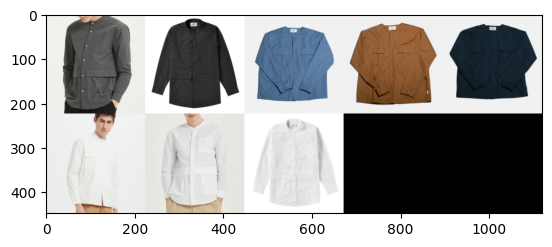


extra featres in 188 but not in 189 = {}


extra featres in 189 but not in 188 = {}


featres in both 188 and 189 = {'boysnextdoor': 0.007833017328679241, 'boysnextdoor round': 0.0019230306090270066, 'collar': 0.0027194227364890425, 'collar shirt': 0.002198288684117379, 'grey': 0.002534970125215287, 'round': 0.003053364975807015, 'round collar': 0.002122231148091583, 'shirt': 0.0037380477486697763, 'shirt grey': 0.00041334492603732983}



In [4]:
output = FindAllGroups(store_domain)

In [5]:
def ProductVariantDifference(output):
    import json
    output_json = json.loads(output)
    out_list = []
    for i in range(len(output_json)):
        diff_dict = {}
        product_handles = [item.split("/")[-1] for item in output_json[i]['product variations']]
        product_handles_split = [item.split("-") for item in product_handles]
        intersection = list(set.intersection(*map(set,product_handles_split)))
        difference_list = [list(set(item).difference(intersection)) for item in product_handles_split]
        diff_dict['difference'] = difference_list
        diff_dict['intersection'] = intersection
        out_list.append(diff_dict)
    out = json.dumps(out_list)
    print(out)
    return out

In [6]:
out = ProductVariantDifference(output)

[{"difference": [["black", "l", "s"], ["l", "grey", "s"], ["l", "navy", "s"], ["white", "l", "s"], ["white", "pocket"], ["beige"], ["black"], ["grey"], ["navy"], ["white"]], "intersection": ["tee", "heavyweight", "beefy", "hanes"]}, {"difference": [["grey"], ["grey", "1"], ["jacket", "blue"], ["brown", "jacket"], ["jacket", "navy"], ["white", "jacket"], ["white"], ["white", "1"]], "intersection": ["collar", "shirt", "boysnextdoor", "round"]}, {"difference": [["brown", "dark"], ["green", "dark"], ["navy"], ["red"], ["pro", "dark", "brown"], ["pro", "dark", "green"], ["pro", "navy"], ["red", "pro"]], "intersection": ["roberu", "leather", "case", "airpods", "factory"]}, {"difference": [["black"], ["black", "new"], ["green"], ["green", "new"], ["grey"], ["khaki"]], "intersection": ["slim", "chino", "boysnextdoor", "pants"]}, {"difference": [["black"], ["blue"], ["charcoal"], ["indigo"], ["orange"], ["white"]], "intersection": ["face", "tee", "the", "cotton", "north", "heavy"]}, {"differenc

In [7]:
import json
out_json = json.loads(out)

In [8]:
out_json[1]

{'difference': [['grey'],
  ['grey', '1'],
  ['jacket', 'blue'],
  ['brown', 'jacket'],
  ['jacket', 'navy'],
  ['white', 'jacket'],
  ['white'],
  ['white', '1']],
 'intersection': ['collar', 'shirt', 'boysnextdoor', 'round']}

In [9]:
# the 'intersection' represents the features that are present throught the group
# the 'difference' represents the features that are present with the pericular product along with the intersection features.